# Denoise Audio

### Notes:
1. To do list
2. Update hf and mf feature transformation frequencies
3. Update input from feature transoformation to include current feature input block
4. ensure metadata contains phase information

In [ ]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout main")
    os.system("git pull origin main")
    #os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin main")
    #os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [ ]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

Notes on testing:
1. SDR is missing as a metric

## Load Model

In [ ]:
from audioautoencoder.models.UNetConv4 import *
from audioautoencoder.training import DenoisingLoader

In [ ]:
import torch

In [ ]:
model_name = 'UNetConv4'
SNRdB_load = [-10, 10]
SNRdB = SNRdB_load
load_file = 'Autoencodermodel_earlystopping.pth'


load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

In [ ]:
# Add the custom class to the safe globals list
torch.serialization.add_safe_globals([UNetConv4])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetConv4(in_channels=4, out_channels=4).to(device)

# Now load your checkpoint normally
denoiser = DenoisingLoader(model, load_path)
model = denoiser.model
print('Loaded Model')

# Example input (batch_size=1, channels=2, height=1025, width=175)
noisy_input = torch.randn(2, 4, 1025 // 4, 175)

denoised_output = denoiser.denoise(noisy_input)
print(denoised_output.shape)

Loaded model from /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth
Loaded Model
torch.Size([2, 4, 256, 175])


In [ ]:
output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/'
scaler_file = output_path + "scalers.pkl"  # Static filename since it's unique per run

from audioautoencoder.datasets.utils import *

if os.path.exists(scaler_file):
    print("Loading existing scalers...")
    scalers = load_scalers(scaler_file)
else:
    print("Training new scalers...")
    scalers = train_scalers_separation(dataset_path, sample_size=8000)
    save_scalers(scalers, scaler_file)

Loading existing scalers...


# Denoise Audio

In [ ]:
from audioautoencoder.denoising import *

In [ ]:
import os

whole_files = '/content/drive/MyDrive/Datasets/Music/MUSDB18/test/'
song_files = []

# Walk through the directory tree
for root, dirs, files in os.walk(whole_files):
    # Filter files with '.wav' extension and 'mixture' in their name
    for f in files:
        if f.endswith('.wav') and 'mixture' in f:
            full_path = os.path.join(root, f)
            song_files.append(full_path)

print(f"\nTotal matching files: {len(song_files)}")


Total matching files: 50


In [ ]:
noise_file = '/content/drive/MyDrive/Datasets/Noise/splits_v2/test/crowd noise (4)_UOHgwM.wav'
#noise_file = '/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/val/plane-noise-passengers-sound_s8OrJQ.mp3'
#noise_file = '/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/val/Crowd - Mall ambience_UdLE4r.wav'
#noise_file = '/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/test/Crowd - Cheering - Strong cheering and soft rhythmic cheering_Pxj5eZ.wav'
#noise_file = '/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/test/Crowd - Street parade with music_FgF6cW.wav'
#noise_file = '/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/test/Robocup 2019 4.1_vTYYoj.mp3'

In [ ]:
def generate_audio_with_noise(audio_file, noise_file, start_time=10, duration=10,
                             signal_level=1, noise_level=0.1, sr=44100, plot=False):
    """
    Loads an audio file and a noise file, trims them, normalizes, and adds Gaussian noise.

    Parameters:
        audio_file (str): Path to the main audio file.
        noise_file (str): Path to the noise file.
        start_time (int): Start time (in seconds) for trimming.
        duration (int): Total duration (in seconds).
        signal_level (float): Scaling factor for the audio signal.
        noise_level (float): Scaling factor for the noise.
        sr (int): Expected sample rate (default: 44100 Hz).

    Returns:
        noisy_audio (np.array): Processed noisy audio.
        snr (float): Signal-to-noise ratio in dB.
    """
    # Load audio and noise
    audio, audio_sr = load_audio_file(audio_file)
    noise_waveform, noise_sr = load_audio_file(noise_file)

    if len(audio) == 2:
      audio = audio[0]

    if len(noise_waveform) == 2:
      noise_waveform = noise_waveform[0]

    # Trim audio and noise to the specified start time and duration

    audio = audio.cpu().numpy() if isinstance(audio, torch.Tensor) else audio
    noise_waveform = noise_waveform.cpu().numpy() if isinstance(noise_waveform, torch.Tensor) else noise_waveform

    print('Noise Sample Rate:', noise_sr)

    assert audio_sr == sr, f"Expected sample rate {sr}, but got {audio_sr}"

    # Trim audio and noise to the specified start time and duration
    audio = audio[start_time * sr : (start_time + duration) * sr]
    noise_waveform = noise_waveform[start_time * noise_sr : (start_time + duration) * noise_sr]

    # Normalize audio to [-1, 1]
    audio = np.clip((audio / np.max(np.abs(audio))) * signal_level, -1, 1)
    noise_waveform = np.clip((noise_waveform / np.max(np.abs(noise_waveform))) * noise_level, -1, 1)

    # Add noise to the signal
    noisy_audio = np.clip(audio + noise_waveform, -1, 1)

    # Compute SNR
    signal_power = np.mean(audio**2)
    noise_power = np.mean(noise_waveform**2)
    snr = 10 * np.log10(signal_power / noise_power)

    print(f"SNR: {snr:.2f} dB")

    # Plot results
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(noise_waveform, label="Noise")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(audio, label="Clean Audio")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(noisy_audio, label="Noisy Audio")
        plt.legend()
        plt.show()

    return noisy_audio, sr

In [ ]:
import os
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import soundfile as sf

def denoise_audio_chunk(chunk, sr, model, scalers, chunk_samples=2*44100, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    features = extract_features(chunk, sr, audio_length=chunk_samples)

    # in thie case, transform features should convert to mel scale
    transformed_features, metadata = transform_features(features, scalers)

    # AI denoising
    input_tensor = torch.tensor(np.array([transformed_features]), dtype=torch.float32).to(device)
    mask = model(input_tensor, return_mask_only=True)

    # here the mask should be re-scaled to linear domain rather than mel domain

    # input tensor should be the spectrogram from the features (pre-transformation to mel scale)
    denoised = input_tensor * mask

    #input_array = input_tensor.detach().cpu().numpy()[0]
    denoised_array = denoised.detach().cpu().numpy()[0]

    denoised_spectrogram = reconstruct_spectrogram(denoised_array, metadata)
    #input_spectrogram = reconstruct_spectrogram(input_array, metadata)

    # Remove lower-than-average values from the spectrogram
    denoised_spectrogram = threshold_spectrogram(denoised_spectrogram, np.mean(denoised_spectrogram), percentage=0.5)

    # De-normalize
    denoised_spectrogram = inverse_scale(denoised_spectrogram, scalers)
    denoised_spectrogram = librosa.db_to_amplitude(denoised_spectrogram)

    output_chunk = magphase_to_waveform(denoised_spectrogram, features['phase'], chunk_samples)

    return output_chunk

class AudioDenoiser:
    def __init__(self, model_one, scalers, output_path, sample_rate=44100, chunk_duration=2, step_size=0.5, device=None):
        """
        Audio Denoising Pipeline using AI model.

        Parameters:
            model (torch.nn.Module): AI model for denoising.
            output_path (str): Directory to save output files.
            sample_rate (int): Sample rate (default 44100 Hz).
            chunk_duration (int): Duration of each chunk in seconds.
            step_size (float): Step size for overlap-add in seconds.
            device (str, optional): Device for PyTorch computation ("cuda" or "cpu").
        """
        self.model_one = model_one
        #self.model_two = model
        self.output_path = output_path
        self.sample_rate = sample_rate
        self.chunk_samples = sample_rate * chunk_duration
        self.scalers = scalers
        self.step_samples = int(self.chunk_samples * step_size)
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model_one.to(self.device)
        self.model_one.eval()
        #self.model_two.to(self.device)
        #self.model_two.eval()

    def process_audio(self, waveform, sr):
        """
        Processes audio by adding noise, chunking, denoising, and reconstructing.

        Parameters:
            input_path (str): Path to the input song file.
            noise_path (str): Path to the noise file.

        Returns:
            Tuple of (reconstructed_audio, reconstructed_audio_input).
        """
        # Load audio
        self.waveform = waveform
        assert sr == self.sample_rate, f"Sample rate mismatch: expected {self.sample_rate}, got {sr}"

        # Process in chunks
        processed_audio, processed_input = [], []
        for start in range(0, len(waveform) - self.chunk_samples + 1, self.step_samples):
            input_chunk = waveform[start:start + self.chunk_samples]

            # --- start denoising
            output_chunk = denoise_audio_chunk(input_chunk, sr, self.model_one, self.scalers, self.chunk_samples, self.device)
            #output_chunk = denoise_audio_chunk(output_chunk, sr, self.model_two, self.scalers, self.chunk_samples, self.device)

            processed_input.append(input_chunk)
            processed_audio.append(output_chunk)

        # Reconstruct waveform with overlap-add
        reconstructed_audio = self._overlap_add(processed_audio)
        reconstructed_audio_input = waveform #self._overlap_add(processed_input)

        # Save output
        self._save_audio(reconstructed_audio, "output_audio_song.wav")
        self._save_audio(reconstructed_audio_input, "input_audio_song.wav")

        # Plot spectrograms
        self._plot_spectrograms(reconstructed_audio, reconstructed_audio_input)

        return reconstructed_audio, reconstructed_audio_input

    def _overlap_add(self, chunks):
        """Reconstructs the waveform using overlap-add method."""
        reconstructed = np.zeros(len(self.waveform))
        weight = np.zeros(len(self.waveform))

        for i, start in enumerate(range(0, len(self.waveform) - self.chunk_samples + 1, self.step_samples)):
            reconstructed[start:start + self.chunk_samples] += chunks[i]
            weight[start:start + self.chunk_samples] += np.hanning(self.chunk_samples)

        reconstructed /= np.maximum(weight, 1e-6)
        reconstructed = np.clip(reconstructed, -1, 1)

        fade_in = int(self.sample_rate / 2)
        reconstructed[:fade_in] *= np.hanning(self.sample_rate)[:fade_in]
        reconstructed[-fade_in:] *= np.hanning(self.sample_rate)[-fade_in:]

        return reconstructed

    def _save_audio(self, audio, filename):
        """Saves the audio file."""
        output_filename = os.path.join(self.output_path, add_datetime_to_filename(filename))
        sf.write(output_filename, audio / np.max(audio), self.sample_rate)
        print(f"Saved: {output_filename}")

    def _plot_spectrograms(self, reconstructed_audio, reconstructed_audio_input, ):
        """Plots spectrograms of processed and input audio with consistent color scale."""

        import librosa
        import librosa.display
        import numpy as np
        import matplotlib.pyplot as plt

        # Compute Mel spectrograms
        Sxx1 = librosa.feature.melspectrogram(y=reconstructed_audio, sr=self.sample_rate, n_fft=2048, hop_length=1024)
        Sxx2 = librosa.feature.melspectrogram(y=reconstructed_audio_input, sr=self.sample_rate, n_fft=2048, hop_length=1024)

        # Convert to log scale (dB)
        Sxx1_db = librosa.amplitude_to_db(Sxx1, ref=np.max)
        Sxx2_db = librosa.amplitude_to_db(Sxx2, ref=np.max)

        # Compute shared color limits
        vmin, vmax = min(Sxx1_db.min(), Sxx2_db.min()), max(Sxx1_db.max(), Sxx2_db.max())

        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

        # Plot processed audio spectrogram
        img1 = librosa.display.specshow(Sxx1_db, sr=self.sample_rate, hop_length=1024, cmap="viridis", ax=axes[0], vmin=vmin, vmax=vmax, y_axis="mel")
        axes[0].set_title("Spectrogram of Processed Audio")
        axes[0].set_xlabel("Time (s)")
        axes[0].set_ylabel("Frequency (Hz)")

        # Plot input spectrogram
        img2 = librosa.display.specshow(Sxx2_db, sr=self.sample_rate, hop_length=1024, cmap="viridis", ax=axes[1], vmin=vmin, vmax=vmax, y_axis="mel")
        axes[1].set_title("Spectrogram of Input Audio")
        axes[1].set_xlabel("Time (s)")

        # Add shared colorbar
        fig.colorbar(img1, ax=axes, orientation="vertical", fraction=0.02, pad=0.02, label="Amplitude (dB)")

        plt.show()

        files.download(file_path)

def resample_feature(feature, target_shape):
    """Resamples a 2D numpy feature array to match target shape using torch.nn.functional.interpolate."""
    feature_tensor = torch.tensor(feature, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
    target_size = (target_shape[0], target_shape[1])  # (new_H, new_W)

    resized_feature = F.interpolate(feature_tensor, size=target_size, mode="bilinear", align_corners=False)
    return resized_feature.squeeze(0).squeeze(0).numpy()  # Remove batch/channel dim and return as numpy

def reconstruct_spectrogram(outputs, metadata):
    # lets evaluate this from a l1 loss perspective
    # reconstruct spectrogram
    out_spectrogram = np.array(outputs[0])
    out_spectrogram[metadata["freq_indices_hf"], :] = resample_feature(outputs[1], metadata["hf_shape"])
    out_spectrogram[metadata["freq_indices_mf"], :] = resample_feature(outputs[2], metadata["mf_shape"])
    out_spectrogram[metadata["freq_indices_lf"], :] = resample_feature(outputs[3], metadata["lf_shape"])
    return out_spectrogram

def inverse_scale(out_spectrogram, scalers):
    # inverse scale the
    # transform back to 0 centred and
    out_spectrogram = (out_spectrogram - 0.5) * 2
    out_spec_shape = out_spectrogram.shape

    # undo scaler
    out_spectrogram = scalers["input_features_spectrogram"].inverse_transform(np.array([out_spectrogram]).reshape(1, -1)).reshape(out_spec_shape)
    return out_spectrogram

def threshold_spectrogram(spectrogram, threshold, percentage=0.8):
    """
    Zeroes out all values in the spectrogram that are below the given threshold.

    Args:
        spectrogram (np.ndarray): Input 2D array.
        threshold (float): The threshold value.

    Returns:
        np.ndarray: The processed spectrogram with values below threshold set to zero.
    """
    spectrogram = np.where(spectrogram >= threshold * percentage, spectrogram, 0)
    return spectrogram

def magphase_to_waveform(magnitude, phase, audio_length=44100):
    """
    Converts a spectrogram image back into an audio waveform.

    Parameters:
        image (np.array): Spectrogram image (3 channels).
        sr (int): Sampling rate.

    Returns:
        np.array: Reconstructed audio waveform.
    """
    stft = magnitude * np.exp(1j * phase)
    return librosa.istft(stft, length=audio_length)

In [ ]:
import numpy as np
import torch
import torchaudio
from torchaudio.io import CodecConfig      # ← new import
from google.colab import files


def save_mp3(
    file_path: str,
    audio_array: np.ndarray,
    sample_rate: int,
    qscale: int = 2,            # 0 (best) … 9 (smallest file), per FFmpeg/LAME
):
    """
    Save a NumPy waveform to an MP3 (VBR) and offer it for download in Colab.

    Parameters
    ----------
    file_path   : str        Path ending in ".mp3"
    audio_array : np.ndarray Shape (N,) or (N, C)
    sample_rate : int        Hz
    qscale      : int        FFmpeg VBR quality: 0=best • 9=worst/smallest
    """

    # --- numpy ➜ torch tensor, (channels, frames) ---------------------------
    waveform = torch.as_tensor(audio_array, dtype=torch.float32)
    if waveform.ndim == 1:          # mono
        waveform = waveform.unsqueeze(0)
    else:                           # (frames, channels) ➜ (channels, frames)
        waveform = waveform.T

    # Optional peak normalisation to prevent clipping
    peak = waveform.abs().max()
    if peak > 1:                    # assume float in -1…1 range
        waveform /= peak

    # --- MP3 write via FFmpeg backend --------------------------------------
    codec_cfg = CodecConfig(qscale=qscale)     # VBR qscale 0-9
    torchaudio.save(
        file_path,
        waveform,
        sample_rate,
        format="mp3",
        compression=codec_cfg,                 # ← must be CodecConfig now
    )

    # --- Trigger browser download in Colab ---------------------------------
    files.download(file_path)


Noise Sample Rate: 44100
SNR: 1.20 dB
Saved: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/output_audio_song_20250505_124214.wav
Saved: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/input_audio_song_20250505_124214.wav


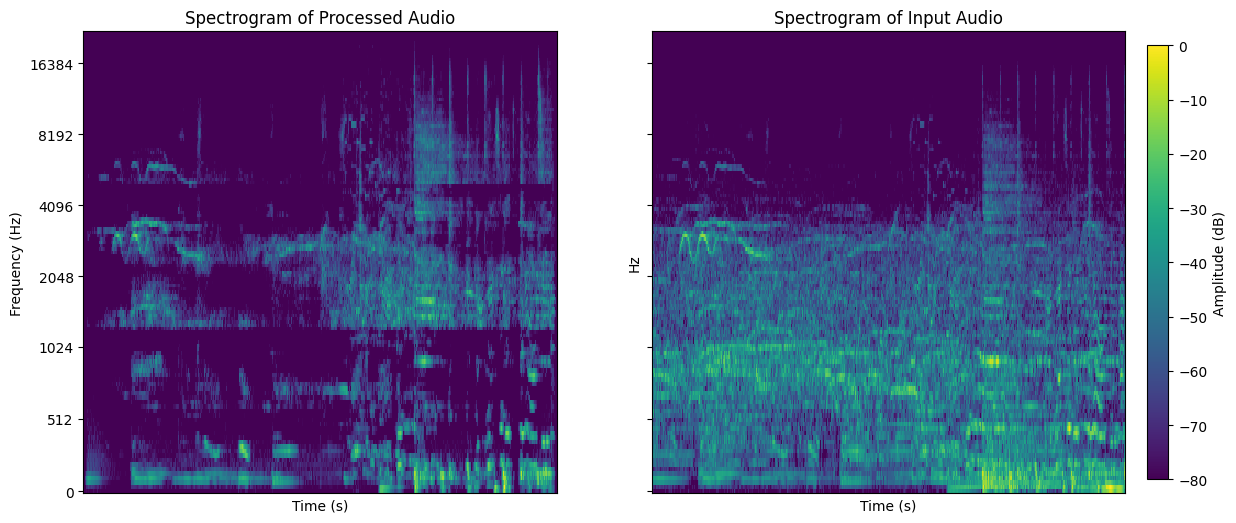

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Noise Sample Rate: 44100
SNR: 5.29 dB
Saved: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/output_audio_song_20250505_124217.wav
Saved: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/input_audio_song_20250505_124217.wav


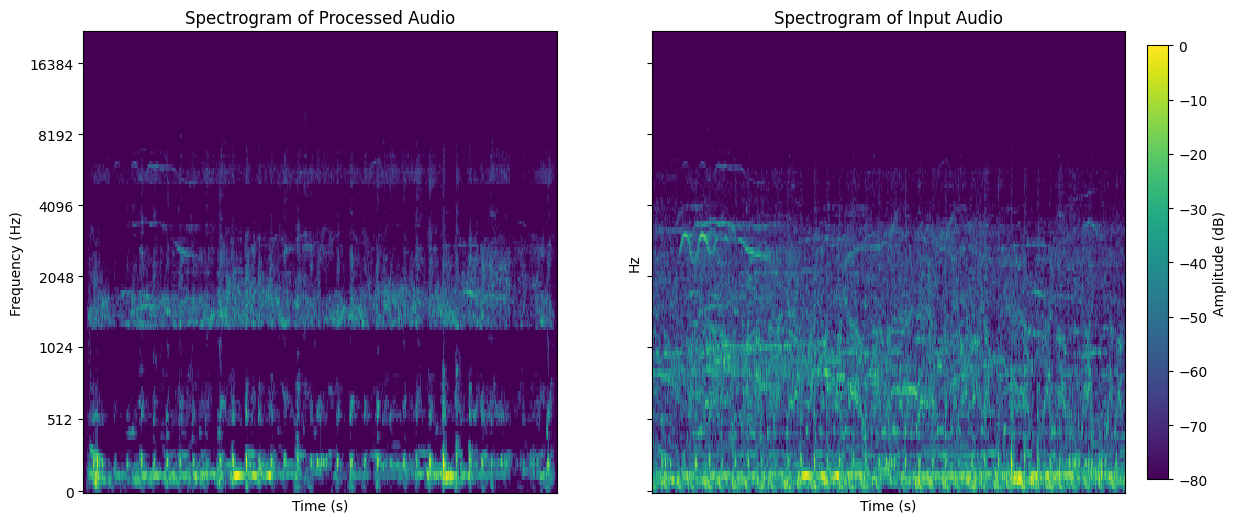

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Noise Sample Rate: 44100
SNR: 6.93 dB
Saved: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/output_audio_song_20250505_124221.wav
Saved: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/input_audio_song_20250505_124221.wav


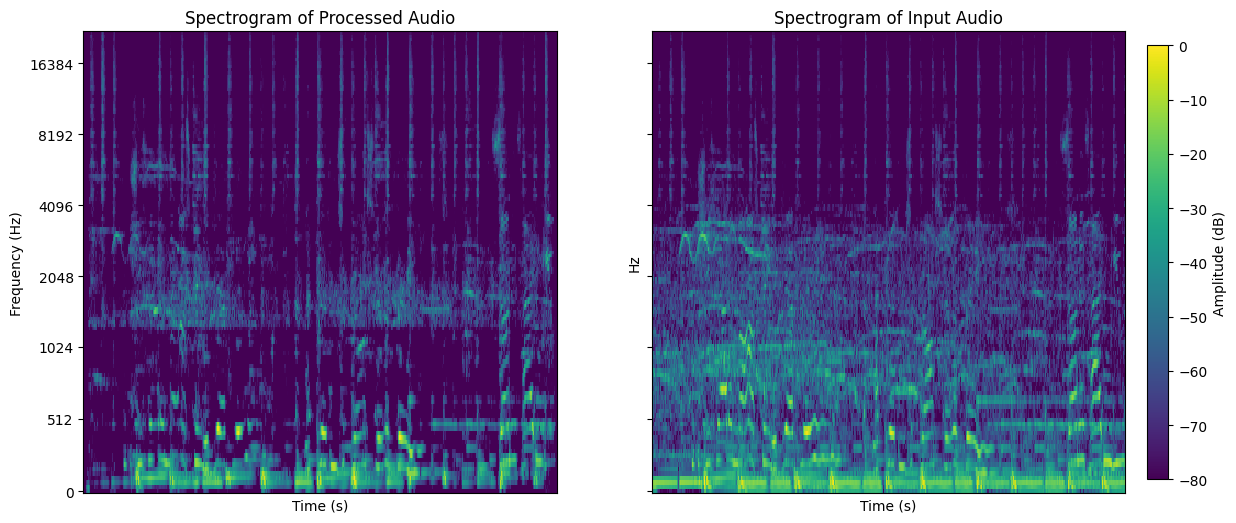

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Noise Sample Rate: 44100
SNR: 5.37 dB
Saved: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/output_audio_song_20250505_124225.wav
Saved: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/input_audio_song_20250505_124225.wav


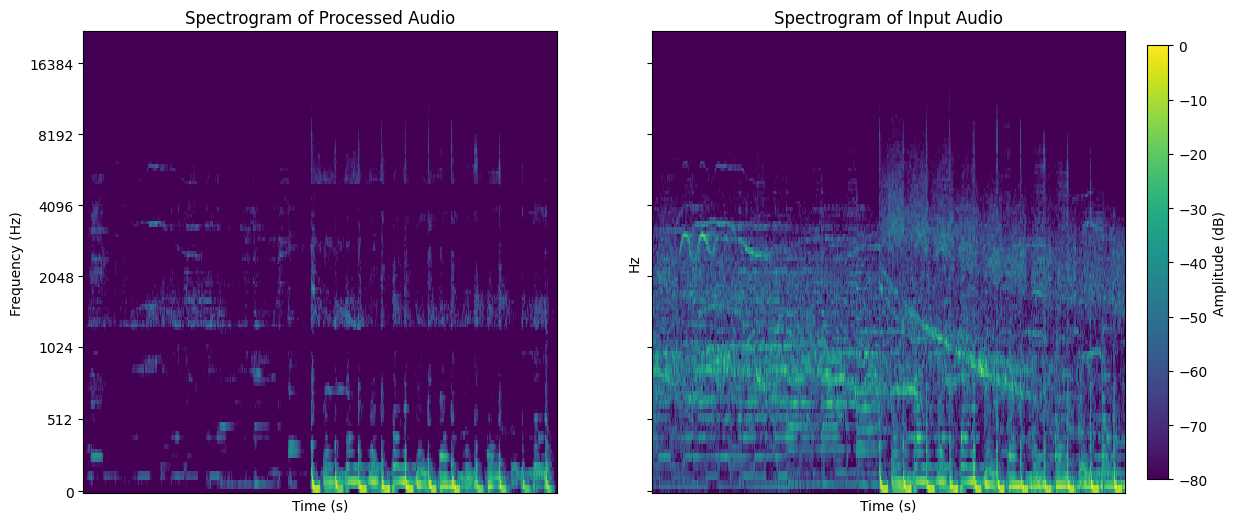

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Noise Sample Rate: 44100
SNR: 7.99 dB
Saved: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/output_audio_song_20250505_124229.wav
Saved: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/input_audio_song_20250505_124229.wav


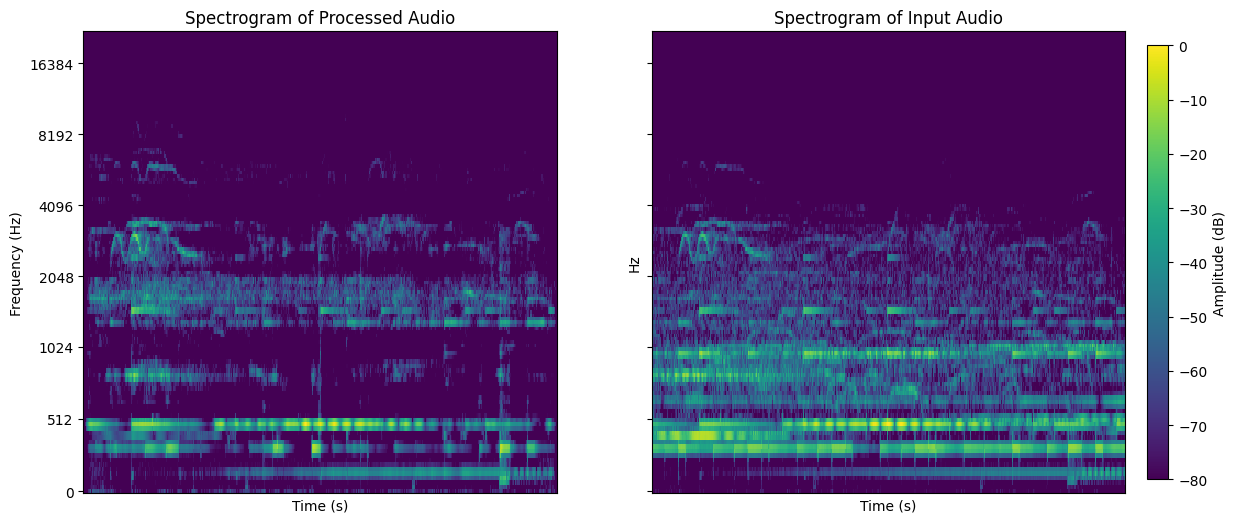

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Noise Sample Rate: 44100
SNR: 5.36 dB
Saved: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/output_audio_song_20250505_124233.wav
Saved: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/input_audio_song_20250505_124233.wav


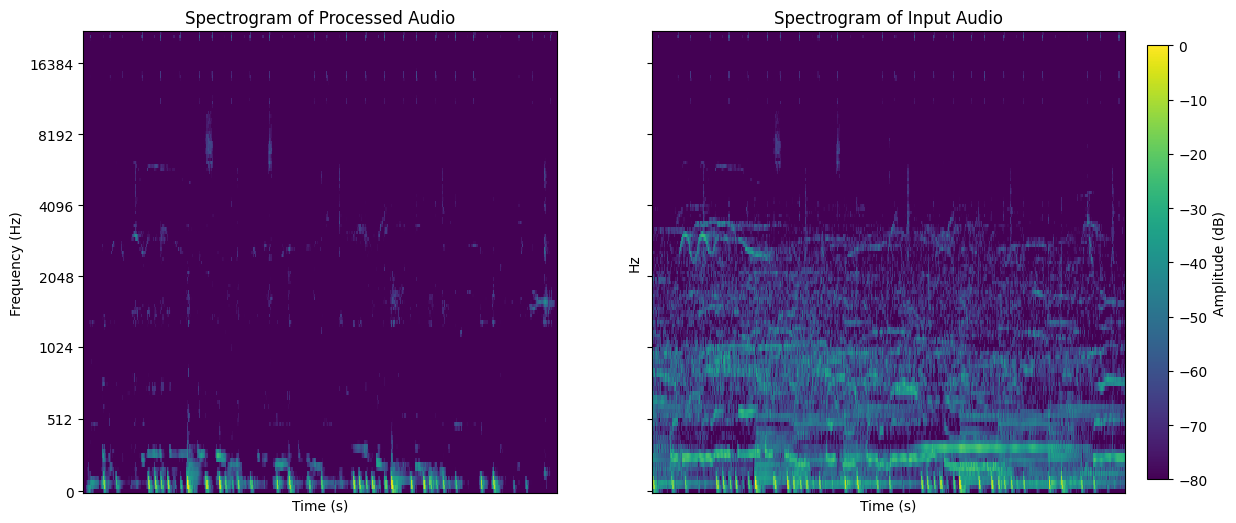

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for file_number in [1, 10, 25, 30, 36, 45]:
  noisy_audio, sr = generate_audio_with_noise(song_files[file_number], noise_file, start_time=20, duration=10, noise_level=0.5)
  denoiser = AudioDenoiser(model, scalers, output_path=output_path, chunk_duration=2, step_size=0.5)
  reconstructed_audio, reconstructed_input = denoiser.process_audio(noisy_audio, sr)

  import soundfile as sf
  from google.colab import files

  save_mp3(f"{file_number:03d}_{model_name}_output.mp3", reconstructed_audio, sr)
  save_mp3(f"{file_number:03d}_{model_name}_input.mp3", reconstructed_input, sr)

---